In [2]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 135.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 608.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 3.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 3.4 MB/s eta 0:00:0000:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


In [4]:
from datasets import load_dataset

# Loading the Hindi dataset from MultiCoNER v2
dataset = load_dataset("MultiCoNER/multiconer_v2", "Hindi (HI)")

0000.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/78.6k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/2.34M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9632 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/514 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/18399 [00:00<?, ? examples/s]

In [6]:
import numpy as np # linear algebra
import pandas as pd

df = dataset['train'].to_pandas()

In [7]:
# Read the replacement mapping file
replacementMapping = {}


def change_fine_to_coarse():
    """
    :params: void
    changes all the fine tags of the dataset to the coarse tags
    :return: void
    """
    with open('input/fine2coarse/MCN2_fine_to_coarse.txt', 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            original = parts[0]
            replacement = parts[1] if len(parts) > 1 else ''
            replacementMapping[original] = replacement

    df['coarse_tags'] = None

    for index, row in df.iterrows():
        transformed_tags = []
        for tag in row['ner_tags']:
            new_tag = 'O'
            if(tag!='O'):
                prefix, entity = tag.split('-', 1)
                if entity in replacementMapping:
                    new_entity = replacementMapping[entity]
                    if new_entity:
                        new_tag = f"{prefix}-{new_entity}"
            transformed_tags.append(new_tag)
        df.at[index, 'coarse_tags'] = transformed_tags

In [8]:
change_fine_to_coarse()

In [10]:
import matplotlib.pyplot as plt

def show_coarse_label_distribution():
    count = {}
    for _, row in df.iterrows():
        nerTags = list(row['ner_tags'])
        for index, ctag in enumerate(row['coarse_tags']):
            if ctag!='O' :
                tag = ctag.split('-', 1)[1]
                nerTag = nerTags[index].split('-', 1)[1]
                if tag in count.keys():
                    if nerTag in count[tag]:
                        count[tag][nerTag]+=1
                    else:
                        count[tag][nerTag]=1
                else:
                    count[tag] = dict()
                    count[tag][nerTag]=1

    for ctag in count.keys():
        # Extract the keys and values from the dictionary
        labels = list(count[ctag].keys())
        sizes = list(count[ctag].values())

        # Create a pie chart
        plt.figure(figsize=(8, 8))  # Optional: Set the size of the figure
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

        # Optional: Add a title
        plt.title(f'Pie Chart for tag {ctag}')

        # Display the chart
        plt.show()

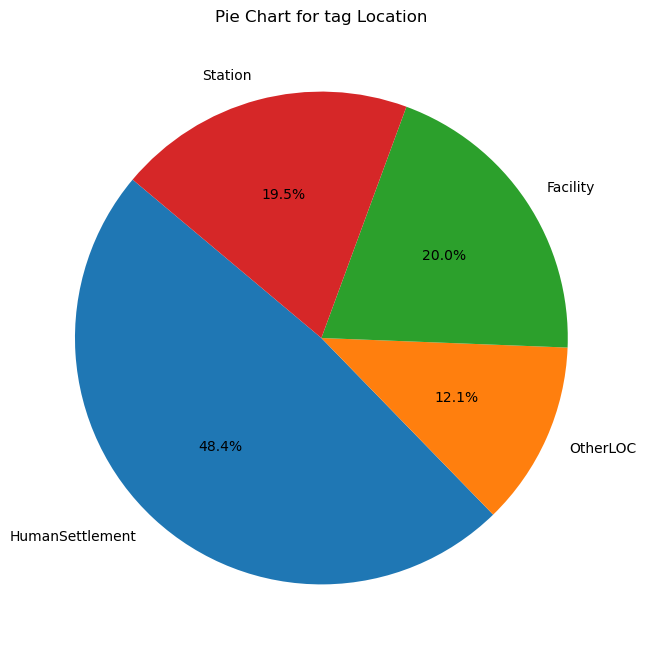

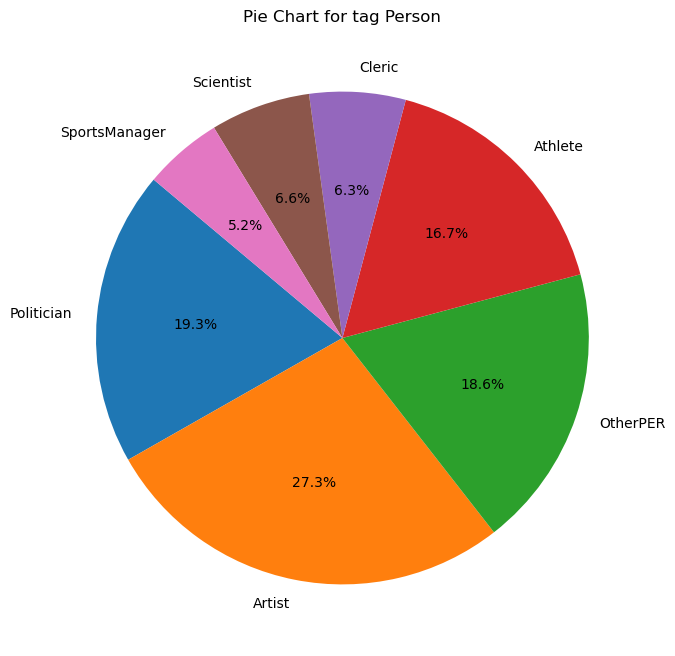

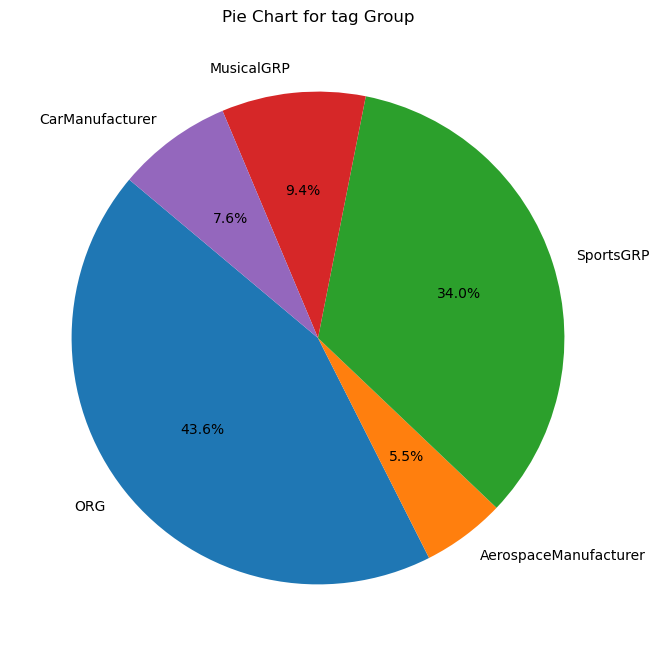

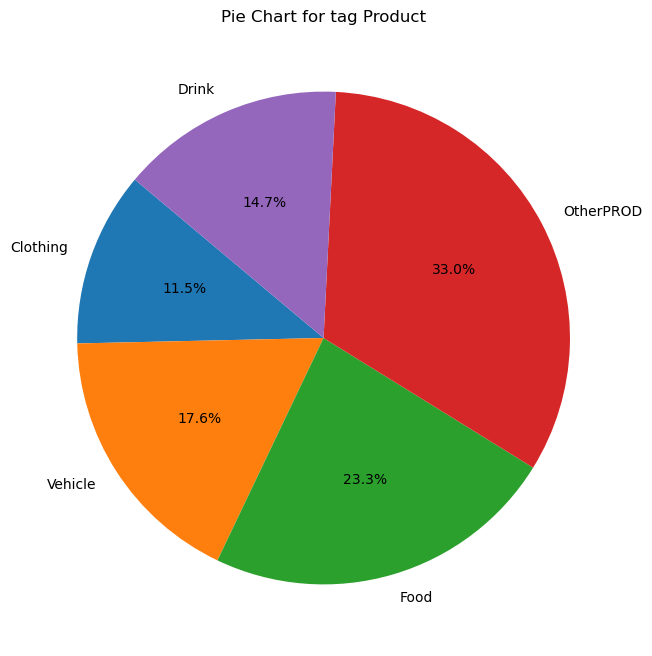

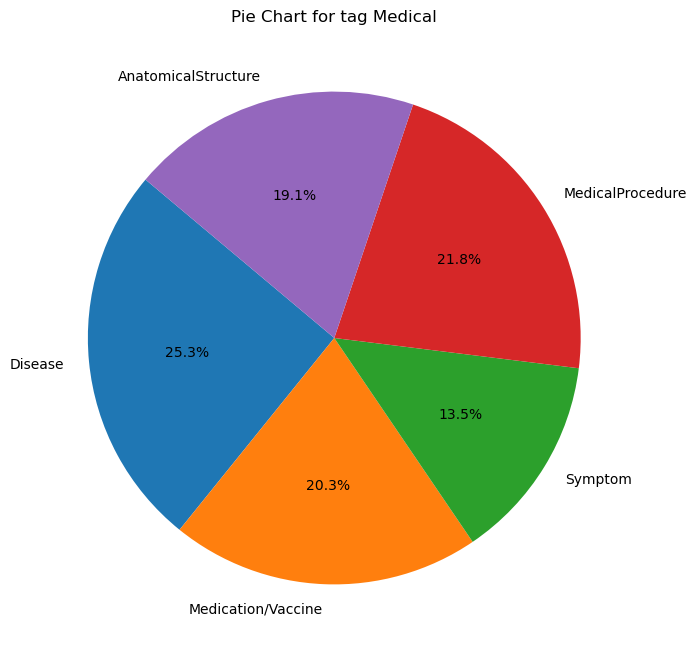

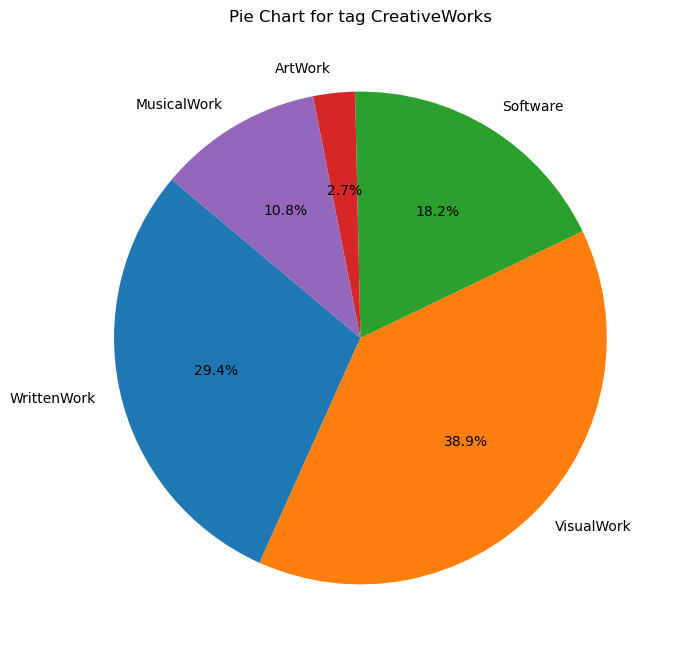

In [11]:
show_coarse_label_distribution()

In [12]:
def take_fine_labelled_sentences(sentences_per_label):
    """
    :param sentences_per_label: number of sentences required per label
    :return: sentences -> map of string (fine-tag) with :
             vector<string> (vector of sentences which have atleast this fine-tag)
    """
    sentences = dict()
    for index, row in df.iterrows():
        string = row['tokens']
        last_tag = 'O'
        for tag in row['ner_tags']:
            if tag!='O':
                refined_tag = tag.split('-')[1]
                if refined_tag != last_tag:
                    if refined_tag in sentences.keys():
                        # we are taking atmost sentencesPerLabel sentences for each fine-tag
                        if len(sentences[refined_tag])<sentences_per_label:
                            sentences[refined_tag].append((string, (list(row['ner_tags']), list(row['coarse_tags']))))
                    else:
                        sentences[refined_tag] = [(string, (list(row['ner_tags']), list(row['coarse_tags'])))]
                last_tag = refined_tag
    return sentences

In [13]:
possibleFineForCoarse = {}

for key, value in replacementMapping.items():
    if value not in possibleFineForCoarse:
        possibleFineForCoarse[value] = set()  # Initialize with an empty set if not present
    possibleFineForCoarse[value].add(key)

In [15]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 220.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.9/300.9 kB 1.4 MB/s eta 0:00:0000:0100:01


In [93]:
import requests
import json
import os

from openai import OpenAI

client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

def generate_lfs_from_llama(sentence, fine_lables, coarse_labels, target_label, flag):
    """
    :param sentence: the sentence for which LFs are required
    :param fine_lables: fine labels for the sentence
    :param coarse_labels: coarse labels for the sentence
    :param target_label: target fine label
    :param flag: which LF (contextBased/fullSentence) is required
    :return: LF in the form of a string message
    """
    for index, word in enumerate(sentence):
        if target_label not in fine_lables[index]:
            coarse_labels[index] = 'O'

    llama_prompt = dict()
    llama_prompt['fullSentence'] = f"""
                    Please write a labelling function for the fine label {target_label}
                    for the following hindi sentence, whose coarse labels have also been
                    provided. This coarse label may have many other fine labels under it,
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of whole sentence and find the fine label that fits best to this coarse label.
                    Don't hardcode based off one sentence, since another test sentence can
                    easily beat the hardcoded labelling function. name the labelling_function in python code as lf1_{np.random.randint(0, 100000000000000, size=1)}. Please don't make lambda labelling functions.
                    sentence: {sentence},
                    coarse labels: {coarse_labels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacementMapping[target_label]]}
                    The labelling function should take in input the sentence list, the coarse
                    label list, and should return a list where each entry is either 'O' or {target_label}.
                    Only provide the python code, without the back-ticked `python written and nothing else in conversation for the LF, without any formatting done through `
                """
    llama_prompt['contextBased'] = f"""
                    Please write a labelling function for the fine label {target_label}
                    for the following hindi sentence, whose coarse labels have also been
                    provided. This coarse label may have many other fine labels under it,
                    the list of possible fine labels against the coarse label is also given.
                    You have to create a labelling function that takes into account the context
                    of size three on either side of the labelled NER and find the fine label that
                    fits best to this coarse label. Don't hardcode based off one sentence,
                    since another test sentence can easily beat the hardcoded
                    labelling function. name the labelling_function in python code as lf2_{np.random.randint(0, 10000000000000000, size=1)}. Please don't make lambda labelling functions.
                    sentence: {sentence},
                    coarse labels: {coarse_labels},
                    possible fine labels for the coarse label: {possibleFineForCoarse[replacementMapping[target_label]]}
                    The labelling function should take in input the sentence list, the coarse
                    label list, and should return a list where each entry is either 'O' or {target_label}.
                    Only provide the python code, without the back-ticked `python written, and nothing else in conversation for the LF, without any formatting done through `
                """

    completion = client.chat.completions.create(
        model="model-identifier",
        messages=[
            {"role": "system", "content": ""},
            {"role": "user", "content": llama_prompt[flag]}
        ],
        temperature=0.7,
    )

    return completion.choices[0].message.content

In [94]:
def process_and_write_code(code: str, filename: str):
    """
    Processes the given Python code by converting '\n' to actual newlines
    and writes it to a file.

    Args:
    - code (str): The Python code as a string, where newlines are represented by '\n'.
    - filename (str): The file path where the processed code will be written.
    """
    # Replace the escaped newline characters with actual newlines
    processed_code = code.replace('\\n', '\n')

    # Write the processed code to the specified file
    with open(filename, 'a') as file:
        file.write(processed_code)
        file.write('\n')
        file.write('\n')

    print(f'Code saved at {filename}')

In [95]:
def serialize_lf(lf):
    """
    Check if lf is a complex object, convert it to a dict or string that can be serialized
    :param lf: labelling function text
    :return: serializable object
    """
    if isinstance(lf, dict):
        return lf
    elif isinstance(lf, list):
        return [serialize_lf(item) for item in lf]  # recursively convert list items
    else:
        return str(lf)  # convert other types to string as a fallback

# sentenceToLFDict -> holds the two LFs corresponding to the sentence generated by GPT
sentenceToLFDict = dict()

def create_lfs_for_sentences(sentences_per_label):
    file_name = "output/lfs.py"
    sentences = take_fine_labelled_sentences(sentences_per_label)
    for target_label in sentences:
        i = 0
        collection_of_sentences = sentences[target_label]
        for sentence, labels in collection_of_sentences:
            print(f'{target_label}, {i}')
            fine_labels = labels[0]
            coarse_labels = labels[1]
            if target_label == 'PublicCorp':
                target_label = 'PublicCORP'
            elif target_label == 'PrivateCorp':
                target_label = 'PrivateCORP'
            full_sentence_lf = generate_lfs_from_llama(sentence, fine_labels, coarse_labels, target_label, 'fullSentence')
            context_based_lf = generate_lfs_from_llama(sentence, fine_labels, coarse_labels, target_label, 'contextBased')
            process_and_write_code(full_sentence_lf, file_name)
            process_and_write_code(context_based_lf, file_name)
            sentenceToLFDict[' '.join(sentence)] = [ serialize_lf(full_sentence_lf),
                                                     serialize_lf(context_based_lf)]
            i = i+1
            break
        break

    file_path = "output/sentence_to_lf_dict.txt"
    with open(file_path, "w", encoding="utf-8") as file:
        json.dump(sentenceToLFDict, file, ensure_ascii=False)

    print(f"Dictionary saved to {file_path}")

In [96]:
create_lfs_for_sentences(0)

HumanSettlement, 0
Code saved at output/lfs.py
Code saved at output/lfs.py
Dictionary saved to output/sentence_to_lf_dict.txt
